In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df_train = pd.read_csv('gp2_data_2006_to_2015.csv')

In [3]:
df_test = pd.read_csv('gp2_data_2016_to_2020.csv')

In [4]:
date_df = df_test['Date']
df_test.shape

(1259, 11)

In [5]:
predict_period = 1259

In [6]:
df_train.set_index(['Date'],inplace=True)
df_test.set_index(['Date'],inplace=True)

In [7]:
# Compute initial covariances
V_1 = (df_train/100).cov().values

In [8]:
# Compute covariance matrix and volatility for t1
V_all = []
V_all.append(V_1)
Volatility = []
Volatility.append([np.sqrt(V_1[i,i]) for i in range(0, 10)])

In [9]:
# Compute covariance matrix for each t from 2016 to 2020
gamma = 0.05
alpha = 0.03
beta = 0.92
V_L = V_1
V_prev = V_1
r_validate_prev = df_test.iloc[0].values[np.newaxis]/100
volatility = []
for k in range(1, df_test.shape[0]):
    V_t = gamma*V_L + alpha*(r_validate_prev.T @ r_validate_prev) + beta * V_prev
    V_all.append(V_t)
    Volatility.append([np.sqrt(V_t[i,i]) for i in range(0, df_test.shape[1])])
    V_prev = V_t 
    r_validate_prev = df_test.iloc[k].values[np.newaxis]/100

## Portfolios Construction

### Q1.2.1 visualize the estimated dynamic volatilities from 2016 to 2020

In [10]:
# Compute daily volatility for each stock
daily_volatilty = pd.DataFrame(Volatility, columns=[asset for asset in df_test.columns])
daily_volatilty.index = date_df

<AxesSubplot:xlabel='Date'>

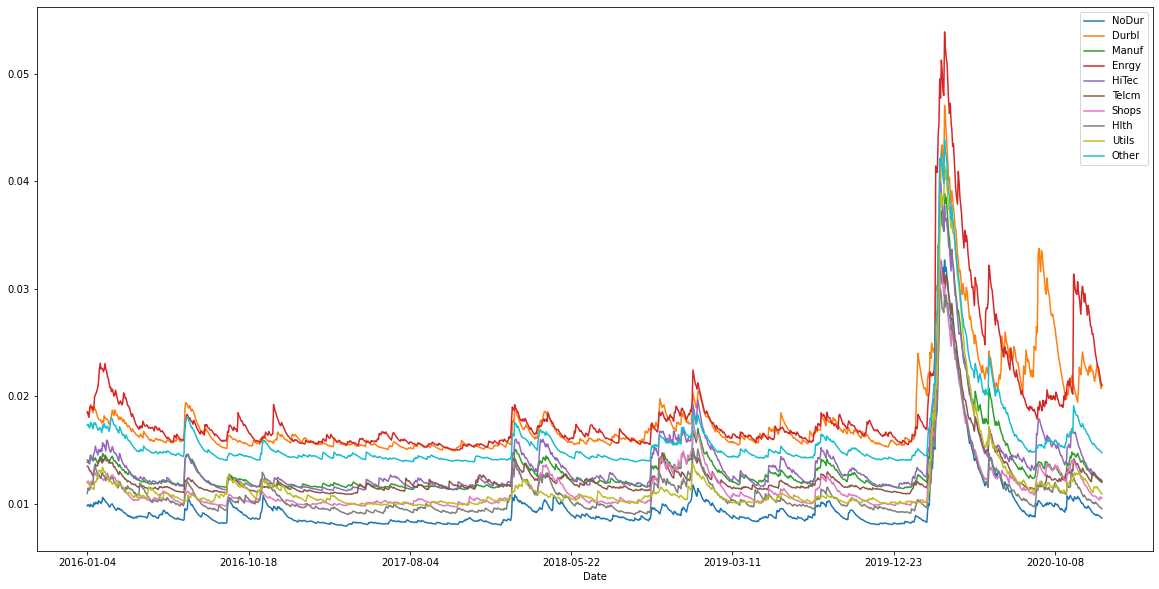

In [11]:
# Q1.2.1 Plot daily volatility on one single plot
daily_volatilty.plot.line(figsize=(20,10))

### Q1.2.2 visualize the correlation matrices on 4 January 2016 and 25 March 2020

In [12]:
# Define function to convert covariance matrix to correlation matrix
def cov_to_corr(M):
    Res = np.zeros(M.shape)
    for i in range(0, M.shape[0]):
        for j in range(0, M.shape[1]):
            Res[i][j] = M[i][j]/((M[i][i]*M[j][j])**0.5)
    return Res

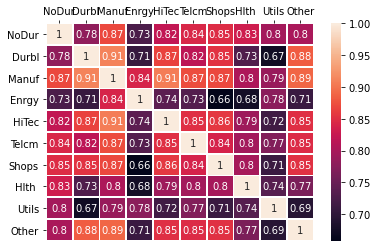

In [13]:
# Correlation matrix on 4-Jan-2016
date = '2016-01-04'
V_jan = V_all[date_df[date_df==date].index[0]]
V_jan = cov_to_corr(V_jan)
ax = sns.heatmap(V_jan, linewidth=0.8, xticklabels=df_test.columns, yticklabels=df_test.columns,annot=True)
ax.xaxis.tick_top() # x axis on top
plt.show()

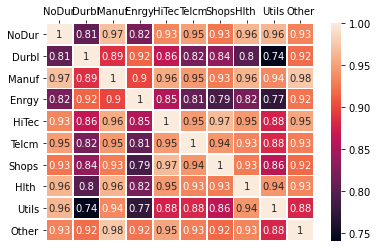

In [14]:
# Correlation matrix on 25-Mar-2020
date = '2020-03-25'
V_mar = V_all[date_df[date_df==date].index[0]]
V_mar = cov_to_corr(V_mar)
ax = sns.heatmap(V_mar, linewidth=0.8, xticklabels=df_test.columns, yticklabels=df_test.columns,annot=True)
ax.xaxis.tick_top() # x axis on top
plt.show()

### Q1.2.3 report and visualize the three portfolio weights

In [15]:
def Vshrink_calculator(V,CORR,delta):
    
    corr_n=np.shape(CORR)[0]
    aver_cov= (np.sum(CORR)-corr_n)/(corr_n**2-corr_n)
    VCC=V.copy()
    for i in range(corr_n):
        for j in range(corr_n):
            if i!=j:
                VCC[i][j]= (V[i][j]/CORR[i][j])*aver_cov
                
    Vshrink= delta*VCC+(1-delta)*V
    
    return Vshrink

# Define delta
delta = 0.3

# Compute w_static
V_corr = (df_train/100).corr().values
V_cap = (df_train/100).cov().values
# V-shrink
V_shrink = Vshrink_calculator(V_cap, V_corr,delta)

In [16]:
# Compute w_static
w_static = np.linalg.inv(V_shrink) @ np.ones((10,1))
w_static /= np.sum(w_static)
np.round(w_static,2)

array([[ 0.84],
       [-0.23],
       [ 0.03],
       [-0.18],
       [ 0.05],
       [-0.04],
       [ 0.26],
       [ 0.31],
       [ 0.19],
       [-0.23]])

In [17]:
# Compute w_dynamic for 2016-01-04
date = '2016-01-04'
V = V_all[date_df[date_df==date].index[0]]
w_dynamic = np.linalg.inv(V) @ np.ones((10,1))
w_dynamic /= np.sum(w_dynamic)
w_dyn=w_dynamic
np.round(w_dyn,2)

array([[ 0.87],
       [-0.21],
       [-0.02],
       [-0.13],
       [ 0.08],
       [-0.08],
       [ 0.28],
       [ 0.25],
       [ 0.17],
       [-0.22]])

In [18]:
# Compute w_dynamic for 2020-03-25
date = '2020-03-25'
V = V_all[date_df[date_df==date].index[0]]
w_dynamic = np.linalg.inv(V) @ np.ones((10,1))
w_dynamic /= np.sum(w_dynamic)
np.round(w_dynamic,2)

array([[ 0.99],
       [ 0.24],
       [-0.54],
       [ 0.18],
       [-0.84],
       [ 0.23],
       [ 0.58],
       [ 1.73],
       [-0.76],
       [-0.79]])

<Figure size 2160x1440 with 0 Axes>

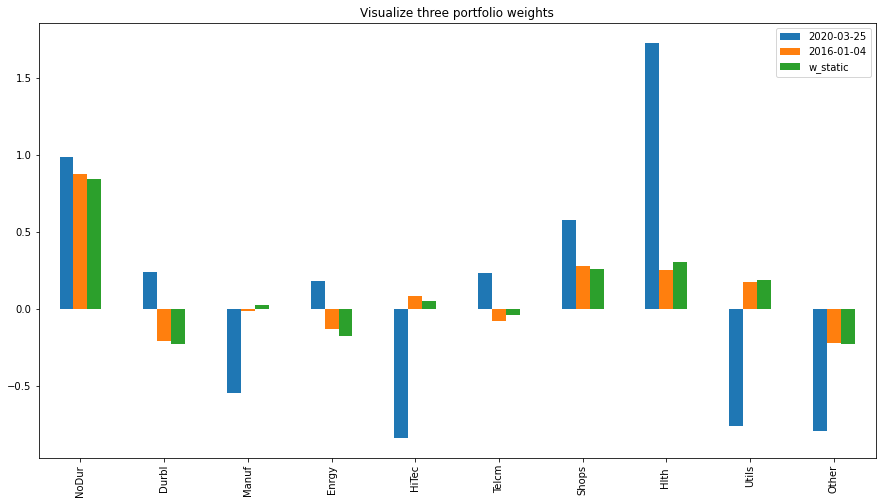

In [19]:
C = df_test.columns
x1=w_dynamic.reshape(1,-1)[0]
x2=w_dyn.reshape(1,-1)[0]
x3=w_static.reshape(1,-1)[0]

dfplot = pd.DataFrame(np.c_[x1,x2,x3], columns=['2020-03-25','2016-01-04','w_static'], index=C)
# plt.figure(figsize=(3, 3))
plt.figure(figsize=(30,20))
dfplot.plot.bar()
plt.title('Visualize three portfolio weights')
plt.gcf().set_size_inches(15, 8)
plt.show()

### Q1.2.4 visualize the total portfolio value under the three portfolio strategies

In [20]:
data2 =df_test/100
data2.head()

,NoDur,Durbl,Manuf,Enrgy,HiTec,Telcm,Shops,Hlth,Utils,Other
Date,,,,,,,,,,
2016-01-04,-0.0131,-0.0189,-0.0140,-0.0029,-0.0162,-0.0118,-0.0161,-0.0225,0.0000,-0.0197
2016-01-05,0.0069,-0.0121,0.0006,0.0035,-0.0045,0.0007,0.0045,0.0048,0.0079,0.0006
2016-01-06,-0.0025,-0.0283,-0.0183,-0.0376,-0.0125,-0.0034,-0.0104,-0.0105,-0.0088,-0.0152
2016-01-07,-0.0160,-0.0323,-0.0255,-0.0236,-0.0309,-0.0123,-0.0147,-0.0234,-0.0113,-0.0290
2016-01-08,-0.0066,-0.0147,-0.0124,-0.0137,-0.0086,-0.0012,-0.0146,-0.0148,0.0020,-0.0146


### I. Equally Weighted Portfolio

In [23]:
r_validate=data2.copy()

In [24]:
w_e= np.array([0.1 for i in range(10)])
w_e= np.reshape(w_e,(-1,1))
w_e

array([[0.1],
       [0.1],
       [0.1],
       [0.1],
       [0.1],
       [0.1],
       [0.1],
       [0.1],
       [0.1],
       [0.1]])

In [25]:
position_init=w_e*1000000
df_ew=data2+1
for j in range(10):
        df_ew.iloc[0,j]= position_init[j] * (df_ew.iloc[0, j])
df_ew['Portfolio Value']=np.sum(df_ew.values, axis = 1)
for i in range(1,len(df_ew)):
    position=w_e*df_ew['Portfolio Value'][i-1]
    for j in range(10):
        df_ew.iloc[i,j]= position[j] * (r_validate.iloc[i, j]+1)
        df_ew['Portfolio Value'][i]=np.sum(df_ew.iloc[i,:10])

df_ew.head()

,NoDur,Durbl,Manuf,Enrgy,HiTec,Telcm,Shops,Hlth,Utils,Other,Portfolio Value
Date,,,,,,,,,,,
2016-01-04,98690.000000,98110.000000,98600.000000,99710.000000,98380.000000,98820.000000,98390.000000,97750.000000,100000.000000,98030.000000,986480.000000
2016-01-05,99328.671200,97454.359200,98707.188800,98993.268000,98204.084000,98717.053600,99091.916000,99121.510400,99427.319200,98707.188800,987752.559200
2016-01-06,98528.317780,95979.916177,96967.668737,95061.306297,97540.565221,98439.420050,97747.993258,97738.115733,97906.033668,97273.872030,973183.208952
2016-01-07,95761.227761,94174.939130,94836.703712,95021.608522,94311.184780,96121.305548,95887.741578,95041.072186,96218.623869,94496.089589,951870.496676
2016-01-08,94558.815140,93787.800037,94006.730252,93882.987087,94368.441040,95072.825208,93797.318742,93778.281332,95377.423767,93797.318742,942427.941349


In [35]:
986480.000000-987752.559200

-1272.5592000000179

### II. Static GMV

In [23]:
# Compute w_static
w_static = np.linalg.inv(V_shrink) @ np.ones((10,1))
w_static /= np.sum(w_static)
w_static

array([[ 0.84420706],
       [-0.23027885],
       [ 0.0254949 ],
       [-0.17613104],
       [ 0.05089502],
       [-0.04201535],
       [ 0.26119552],
       [ 0.3064491 ],
       [ 0.18774626],
       [-0.22756262]])

In [26]:
position_init=w_static*1000000
df_static=data2+1
for j in range(10):
        df_static.iloc[0,j]= position_init[j] * (df_static.iloc[0, j])
df_static['Portfolio Value']=np.sum(df_static.values, axis = 1)
for i in range(1,len(df_static)):
    position=w_static*df_static['Portfolio Value'][i-1]
    for j in range(10):
        df_static.iloc[i,j]= position[j] * (r_validate.iloc[i, j]+1)
        df_static['Portfolio Value'][i]=np.sum(df_static.iloc[i,:10])

df_static.head()

,NoDur,Durbl,Manuf,Enrgy,HiTec,Telcm,Shops,Hlth,Utils,Other,Portfolio Value
Date,,,,,,,,,,,
2016-01-04,833147.944007,-225926.584014,25137.971295,-175620.257284,50070.522784,-41519.565239,256990.272355,299553.991589,187746.263781,-223079.637141,9.865009e+05
2016-01-05,838557.435830,-224421.541519,25165.832700,-174361.567713,49982.050337,-41477.191619,258829.134862,303763.415159,186675.036060,-224625.429674,9.980872e+05
2016-01-06,840485.755009,-223333.945178,24980.468371,-169184.270076,50162.697982,-41792.399370,257984.661412,302651.352003,185738.131112,-223674.997705,1.004017e+06
2016-01-07,834037.041186,-223736.100122,24944.592696,-172665.243756,49520.516273,-41665.276094,258389.861645,300480.523622,186370.469737,-221851.014583,9.938254e+05
2016-01-08,833457.027761,-225492.770352,25023.293604,-172645.397552,50145.769670,-41705.810033,255792.826767,300049.444734,186960.174182,-222855.606336,9.887290e+05


### III. Dynamic GMV

In [27]:
def weight_GMV(V,n):
    w_G = np.linalg.inv(V) @ np.ones((n,1))
    w_G /= np.sum(w_G)
    np.round(w_G,5)
    return w_G 
w_dynamic=np.zeros_like(r_validate)
for t in range(len(r_validate)):
    w_dynamic[t]=weight_GMV(V_all[t],10).flatten()
        
print(w_dynamic)        

[[ 0.873479   -0.20706471 -0.01781659 ...  0.25420755  0.17099706
  -0.22076909]
 [ 0.88060933 -0.21459248 -0.03546739 ...  0.1455147   0.26357962
  -0.23726573]
 [ 0.86447924 -0.14490036 -0.07896556 ...  0.15790644  0.2534592
  -0.2725278 ]
 ...
 [ 0.81912065 -0.09806565 -0.04236947 ...  0.30968177  0.16651483
  -0.22639965]
 [ 0.81772929 -0.09792464 -0.05182182 ...  0.3139529   0.16724659
  -0.22740716]
 [ 0.81849558 -0.08864606 -0.03897531 ...  0.31660443  0.17280124
  -0.23032756]]


In [28]:
position_init=w_dynamic[0]*1000000
df_dynamic=data2+1
for j in range(10):
        df_dynamic.iloc[0,j]= position_init[j] * (df_dynamic.iloc[0, j])
df_dynamic['Portfolio Value']=np.sum(df_dynamic.values, axis = 1)
for i in range(1,len(df_dynamic)):
    position=w_dynamic[i]*df_dynamic['Portfolio Value'][i-1]
    for j in range(10):
        df_dynamic.iloc[i,j]= position[j] * (r_validate.iloc[i, j]+1)
        df_dynamic['Portfolio Value'][i]=np.sum(df_dynamic.iloc[i,:10])

df_dynamic.head()

,NoDur,Durbl,Manuf,Enrgy,HiTec,Telcm,Shops,Hlth,Utils,Other,Portfolio Value
Date,,,,,,,,,,,
2016-01-04,862036.425146,-203151.187444,-17567.162315,-130044.421771,80576.518420,-80822.900471,272809.968079,248487.882543,170997.056497,-216419.940019,9.869022e+05
2016-01-05,875071.940323,-209219.239486,-35023.848488,-117697.840286,84440.943021,-59392.591978,288140.098464,144298.105906,262182.322375,-234298.571854,9.985013e+05
2016-01-06,861025.705368,-140588.664838,-77404.312843,-120237.281956,142246.985680,-40576.394937,239305.447148,156014.259906,250852.245369,-267983.154707,1.002655e+06
2016-01-07,826498.502943,-126466.110801,-75984.594992,-101803.088477,129033.128877,-66961.761158,255624.756382,177047.096103,244986.203624,-270155.923405,9.918182e+05
2016-01-08,820310.609193,-138561.521766,-97535.233885,-92994.856007,47640.281708,7519.554263,342352.891903,133416.486966,260583.182754,-294396.546645,9.883348e+05


In [29]:
# Q1.2.4 Visualize the dynamics of the total portfolio value under the three portfolio strategies
portfolio_value = pd.concat([df_static['Portfolio Value'], df_dynamic['Portfolio Value'], df_ew['Portfolio Value']],axis=1)
portfolio_value.columns=['static_portfolio','dynamic_portfolio','equal_weight_portfolio']

<AxesSubplot:xlabel='Date'>

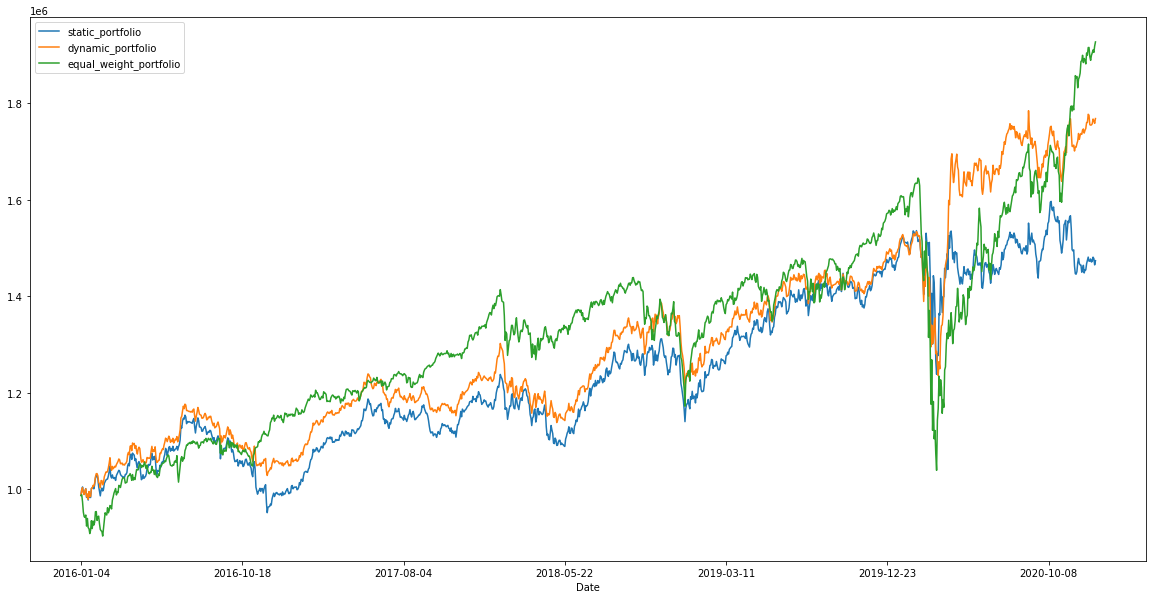

In [30]:
portfolio_value.plot.line(figsize=(20,10))

### Q1.3 Risk Evaluation

### I. Equally Weighted Portfolio

In [31]:
#  VaR and ES for equal weighted portfolio
df_loss=- df_ew['Portfolio Value'] + df_ew['Portfolio Value'].shift(periods=1)
df_loss[0]=1000000-df_ew['Portfolio Value'][0]
df_loss

alpha=0.99

losses = df_loss.sort_values(ascending = False).values

VaR  = np.percentile(losses, alpha * 100, interpolation = 'higher') 
ES = np.mean(losses [losses >= VaR])

print('VaR: ', VaR)
print('ES ', ES)

VaR:  50146.60931750387
ES  78349.82963761728


In [36]:
# Stressed VaR and stressed ES for equal weighted portfolio
stressed_VaR=0
VaR_start=0
stressed_ES=0
ES_start=0
for i in range(1010):
    df_loss_250 = df_loss[i:i+250]
    losses = df_loss_250.sort_values(ascending = False).values
    VaR  = np.percentile(losses, alpha * 100, interpolation = 'higher') 
    ES = np.mean(losses [losses >= VaR])
    
    if VaR>stressed_VaR:
        stressed_VaR=VaR
        VaR_start=i
    if ES>stressed_ES:
        stressed_ES=ES
        ES_start=i
        
print('one-day 99% stressed VaR:',stressed_VaR,'250-day period:',df_loss.index[VaR_start],df_loss.index[VaR_start+249])
print('one-day 99% stressed ES:',stressed_ES,'250-day period:',df_loss.index[ES_start],df_loss.index[ES_start+249])

one-day 99% stressed VaR: 123287.88130546943 250-day period: 2019-03-20 2020-03-16
one-day 99% stressed ES: 132618.59086014275 250-day period: 2019-03-20 2020-03-16


### II. Static GMV

In [37]:
#  VaR and ES for Static GMV portfolio
df_loss=- df_static['Portfolio Value'] + df_static['Portfolio Value'].shift(periods=1)
df_loss[0]=1000000-df_static['Portfolio Value'][0]
# df_loss
alpha=0.99

losses = df_loss.sort_values(ascending = False).values

VaR  = np.percentile(losses, alpha * 100, interpolation = 'higher') 
ES = np.mean(losses [losses >= VaR])

print('VaR: ', VaR)
print('ES ', ES)

VaR:  37473.816406792845
ES  60956.3765543106


In [39]:
# Stressed VaR and stressed ES for Static GMV portfolio
stressed_VaR=0
VaR_start=0
stressed_ES=0
ES_start=0
for i in range(1010):
    df_loss_250 = df_loss[i:i+250]
    losses = df_loss_250.sort_values(ascending = False).values
    VaR  = np.percentile(losses, alpha * 100, interpolation = 'higher') 
    ES = np.mean(losses [losses >= VaR])
    if VaR>stressed_VaR:
        stressed_VaR=VaR
        VaR_start=i
    if ES>stressed_ES:
        stressed_ES=ES
        ES_start=i
        
print('Static GMV: one-day 99% stressed VaR:',stressed_VaR,'250-day period:',df_loss.index[VaR_start],df_loss.index[VaR_start+249])
print('Static GMV: one-day 99% stressed ES:',stressed_ES,'250-day period:',df_loss.index[ES_start],df_loss.index[ES_start+249])

Static GMV: one-day 99% stressed VaR: 100632.12607033807 250-day period: 2019-03-26 2020-03-20
Static GMV: one-day 99% stressed ES: 110281.88921095578 250-day period: 2019-03-26 2020-03-20


### III. Dynamic GMV

In [40]:
df_loss=- df_dynamic['Portfolio Value'] + df_dynamic['Portfolio Value'].shift(periods=1)
df_loss[0]=1000000-df_dynamic['Portfolio Value'][0]

alpha=0.99

losses = df_loss.sort_values(ascending = False).values

VaR  = np.percentile(losses, alpha * 100, interpolation = 'higher') 
ES = np.mean(losses [losses >= VaR])

print('VaR: ', VaR)
print('ES ', ES)

VaR:  37325.28688914771
ES  50168.341056750854


In [41]:
stressed_VaR=0
VaR_start=0
stressed_ES=0
ES_start=0
for i in range(1010):
    df_loss_250 = df_loss[i:i+250]
    losses = df_loss_250.sort_values(ascending = False).values
    VaR  = np.percentile(losses, alpha * 100, interpolation = 'higher') 
    ES = np.mean(losses [losses >= VaR])
    
    if VaR>stressed_VaR:
        stressed_VaR=VaR
        VaR_start=i
    if ES>stressed_ES:
        stressed_ES=ES
        ES_start=i
        
print('one-day 99% stressed VaR:',stressed_VaR,'250-day period:',df_loss.index[VaR_start],df_loss.index[VaR_start+249])
print('one-day 99% stressed ES:',stressed_ES,'250-day period:',df_loss.index[ES_start],df_loss.index[ES_start+249])

one-day 99% stressed VaR: 58281.95146253612 250-day period: 2019-06-17 2020-06-11
one-day 99% stressed ES: 78131.73823996757 250-day period: 2019-06-17 2020-06-11


### Q1.4 Further Thoughts
#### Construction of EWMA model
#### - V 1(i, j) = Vˆ (i, j). That is, the initial value is the sample covariance matrix obtained from the pre-2006 data;
#### - Fort≥2,Vt(i,j)=lambda* VL(i,j)+(1-lambda) × r_validate(t−1,i)×r_validate(t−1,j).

In [190]:
ewma_V_all = []
ewma_V_all.append(V_1)
ewma_Volatility = []
ewma_Volatility.append([V_1[i,i] for i in range(0, 10)])

In [191]:
Lambda = 0.95
V_L = V_1
V_prev = V_1
r_validate_prev = df_test.iloc[0].values[np.newaxis]/100
for k in range(1, df_test.shape[0]):
    V_t = Lambda*V_prev + (1-Lambda)*(r_validate_prev.T @ r_validate_prev)
    ewma_V_all.append(V_t)
    ewma_Volatility.append([V_t[i,i] for i in range(0, df_test.shape[1])])
    V_prev = V_t 
    r_validate_prev = df_test.iloc[k].values[np.newaxis]/100

In [192]:
ewma_w_dynamic=np.zeros_like(r_validate)
for t in range(len(r_validate)):
    ewma_w_dynamic[t]=weight_GMV(ewma_V_all[t],10).flatten()      

In [193]:
position_init=ewma_w_dynamic[0]*1000000
df_ewma=data2+1
for j in range(10):
        df_ewma.iloc[0,j]= position_init[j] * (df_ewma.iloc[0, j])
df_ewma['Portfolio Value']=np.sum(df_ewma.values, axis = 1)
for i in range(1,len(df_ewma)):
    position=ewma_w_dynamic[i]*df_ewma['Portfolio Value'][i-1]
    for j in range(10):
        df_ewma.iloc[i,j]= position[j] * (r_validate.iloc[i, j]+1)
        df_ewma['Portfolio Value'][i]=np.sum(df_ewma.iloc[i,:10])

In [194]:
portfolio_return = pd.concat([df_static['Portfolio Value'], df_dynamic['Portfolio Value'], df_ew['Portfolio Value'],df_ewma['Portfolio Value']],axis=1)
portfolio_return.columns=['static_portfolio','dynamic_portfolio','equal_weight_portfolio','ewma_portfolio']

<AxesSubplot:xlabel='Date'>

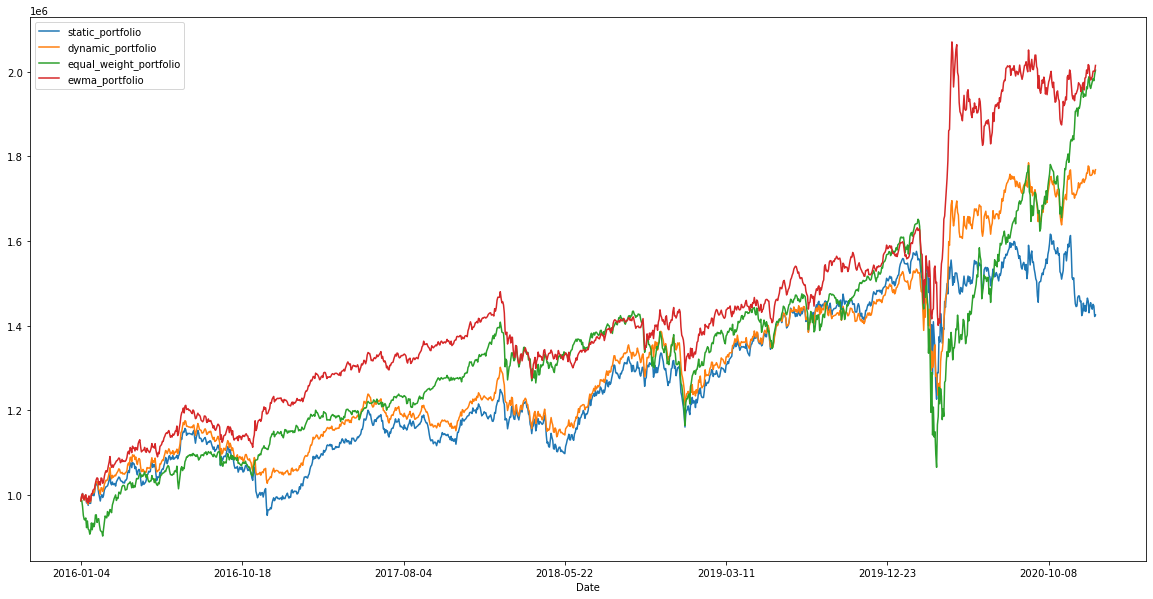

In [195]:
portfolio_return.plot.line(figsize=(20,10))

In [196]:
df_loss=- df_ewma['Portfolio Value'] + df_ewma['Portfolio Value'].shift(periods=1)
df_loss[0]=1000000-df_ewma['Portfolio Value'][0]

alpha=0.99

losses = df_loss.sort_values(ascending = False).values

VaR  = np.percentile(losses, alpha * 100, interpolation = 'higher') 
ES = np.mean(losses [losses >= VaR])

print('VaR: ', VaR)
print('ES ', ES)

VaR:  41406.500182141084
ES  59808.5283084083


In [197]:
stressed_VaR=0
VaR_start=0
stressed_ES=0
ES_start=0
for i in range(1010):
    df_loss_250 = df_loss[i:i+250]
    losses = df_loss_250.sort_values(ascending = False).values
    VaR  = np.percentile(losses, alpha * 100, interpolation = 'higher') 
    ES = np.mean(losses [losses >= VaR])
    
    if VaR>stressed_VaR:
        stressed_VaR=VaR
        VaR_start=i
    if ES>stressed_ES:
        stressed_ES=ES
        ES_start=i
        
print('one-day 99% stressed VaR:',stressed_VaR,'250-day period:',df_loss.index[VaR_start],df_loss.index[VaR_start+249])
print('one-day 99% stressed ES:',stressed_ES,'250-day period:',df_loss.index[ES_start],df_loss.index[ES_start+249])

one-day 99% stressed VaR: 75869.39405767038 250-day period: 2019-04-26 2020-04-22
one-day 99% stressed ES: 82179.32018127968 250-day period: 2019-04-26 2020-04-22


#### Second Approach - GARCH GMV

In [20]:
#### Second Approach - GARCH GMVGARCH_w_dynamic=np.zeros_like(r_validate)
for t in range(len(r_validate)):
    GARCH_w_dynamic[t]=weight_GMV(Vall_new[t],10).flatten() def getVall(a,b,c):
    Vall = []
    Vall.append(V_1)
    gamma = a
    alpha = b
    beta =  c
    V_L = V_1
    V_prev = V_1
    r_validate_prev = df_test.iloc[0].values[np.newaxis]/100
    volatility = []
    for k in range(1, df_test.shape[0]):
        V_t = gamma*V_L + alpha*(r_validate_prev.T @ r_validate_prev) + beta * V_prev
        Vall.append(V_t)
        Volatility.append([V_t[i,i] for i in range(0, df_test.shape[1])])
        V_prev = V_t 
        r_validate_prev = df_test.iloc[k].values[np.newaxis]/100
    return Vall

In [52]:
data2 =df_test/100
r_validate=data2.copy()
def weight_GMV(V,n):
    w_G = np.linalg.inv(V) @ np.ones((n,1))
    w_G /= np.sum(w_G)
    np.round(w_G,5)
    return w_G 

Vall_new=getVall(0.05,0.05,0.9)

In [53]:
GARCH_w_dynamic=np.zeros_like(r_validate)
for t in range(len(r_validate)):
    GARCH_w_dynamic[t]=weight_GMV(Vall_new[t],10).flatten() 

In [55]:
df_loss=- df_GARCH['Portfolio Value'] + df_GARCH['Portfolio Value'].shift(periods=1)
df_loss[0]=1000000-df_GARCH['Portfolio Value'][0]

alpha=0.99

losses = df_loss.sort_values(ascending = False).values

VaR  = np.percentile(losses, alpha * 100, interpolation = 'higher') 
ES = np.mean(losses [losses >= VaR])

print('VaR: ', VaR)
print('ES ', ES)

VaR:  35295.98147890833
ES  49918.657958526004


In [56]:
df_loss=- df_GARCH['Portfolio Value'] + df_GARCH['Portfolio Value'].shift(periods=1)
df_loss[0]=1000000-df_GARCH['Portfolio Value'][0]

alpha=0.99

losses = df_loss.sort_values(ascending = False).values

VaR  = np.percentile(losses, alpha * 100, interpolation = 'higher') 
ES = np.mean(losses [losses >= VaR])

print('VaR: ', VaR)
print('ES ', ES)stressed_VaR=0
VaR_start=0
stressed_ES=0
ES_start=0
for i in range(1010):
    df_loss_250 = df_loss[i:i+250]
    losses = df_loss_250.sort_values(ascending = False).values
    VaR  = np.percentile(losses, alpha * 100, interpolation = 'higher') 
    ES = np.mean(losses [losses >= VaR])
    
    if VaR>stressed_VaR:
        stressed_VaR=VaR
        VaR_start=i
    if ES>stressed_ES:
        stressed_ES=ES
        ES_start=i
        
print('one-day 99% stressed VaR:',stressed_VaR,'250-day period:',df_loss.index[VaR_start],df_loss.index[VaR_start+249])
print('one-day 99% stressed ES:',stressed_ES,'250-day period:',df_loss.index[ES_start],df_loss.index[ES_start+249])

one-day 99% stressed VaR: 59424.14065993251 250-day period: 2019-06-17 2020-06-11
one-day 99% stressed ES: 76664.44501475834 250-day period: 2019-06-17 2020-06-11
